# Detecting Parkinson’s Disease with OpenCV, Computer Vision, and the Spiral/Wave Test

In [1]:
%cd detect-parkinsons

/content/detect-parkinsons


### Import Packages

In [2]:
# import the necessary packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage import feature
from imutils import build_montages
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.figure(figsize=(15, 15))
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing the Parkinson’s detector script

In [4]:
def quantify_image(image):
	# compute the histogram of oriented gradients feature vector for
	# the input image
	features = feature.hog(image, orientations=9,
		pixels_per_cell=(10, 10), cells_per_block=(2, 2),
		transform_sqrt=True, block_norm="L1")

	# return the feature vector
	return features

In [5]:
def load_split(path):
	# grab the list of images in the input directory, then initialize
	# the list of data (i.e., images) and class labels
	imagePaths = list(paths.list_images(path))
	data = []
	labels = []

	# loop over the image paths
	for imagePath in imagePaths:
		# extract the class label from the filename
		label = imagePath.split(os.path.sep)[-2]

		# load the input image, convert it to grayscale, and resize
		# it to 200x200 pixels, ignoring aspect ratio
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		image = cv2.resize(image, (200, 200))

		# threshold the image such that the drawing appears as white
		# on a black background
		image = cv2.threshold(image, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

		# quantify the image
		features = quantify_image(image)

		# update the data and labels lists, respectively
		data.append(features)
		labels.append(label)

	# return the data and labels
	return (np.array(data), np.array(labels))

In [11]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"dataset": "dataset/spiral",  
    "trials": 5
}

In [12]:
# define the path to the training and testing directories
trainingPath = os.path.sep.join([args["dataset"], "training"])
testingPath = os.path.sep.join([args["dataset"], "testing"])

# loading the training and testing data
print("[INFO] loading data...")
(trainX, trainY) = load_split(trainingPath)
(testX, testY) = load_split(testingPath)

# encode the labels as integers
le = LabelEncoder()
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

# initialize our trials dictionary
trials = {}

[INFO] loading data...


In [13]:
# loop over the number of trials to run
for i in range(0, args["trials"]):
	# train the model
	print("[INFO] training model {} of {}...".format(i + 1,
		args["trials"]))
	model = RandomForestClassifier(n_estimators=100)
	model.fit(trainX, trainY)

	# make predictions on the testing data and initialize a dictionary
	# to store our computed metrics
	predictions = model.predict(testX)
	metrics = {}

	# compute the confusion matrix and and use it to derive the raw
	# accuracy, sensitivity, and specificity
	cm = confusion_matrix(testY, predictions).flatten()
	(tn, fp, fn, tp) = cm
	metrics["acc"] = (tp + tn) / float(cm.sum())
	metrics["sensitivity"] = tp / float(tp + fn)
	metrics["specificity"] = tn / float(tn + fp)

	# loop over the metrics
	for (k, v) in metrics.items():
		# update the trials dictionary with the list of values for
		# the current metric
		l = trials.get(k, [])
		l.append(v)
		trials[k] = l

[INFO] training model 1 of 5...
[INFO] training model 2 of 5...
[INFO] training model 3 of 5...
[INFO] training model 4 of 5...
[INFO] training model 5 of 5...


In [14]:
# loop over our metrics
for metric in ("acc", "sensitivity", "specificity"):
	# grab the list of values for the current metric, then compute
	# the mean and standard deviation
	values = trials[metric]
	mean = np.mean(values)
	std = np.std(values)

	# show the computed metrics for the statistic
	print(metric)
	print("=" * len(metric))
	print("u={:.4f}, o={:.4f}".format(mean, std))
	print("")

acc
===
u=0.8333, o=0.0211

sensitivity
u=0.7467, o=0.0499

specificity
u=0.9200, o=0.0267



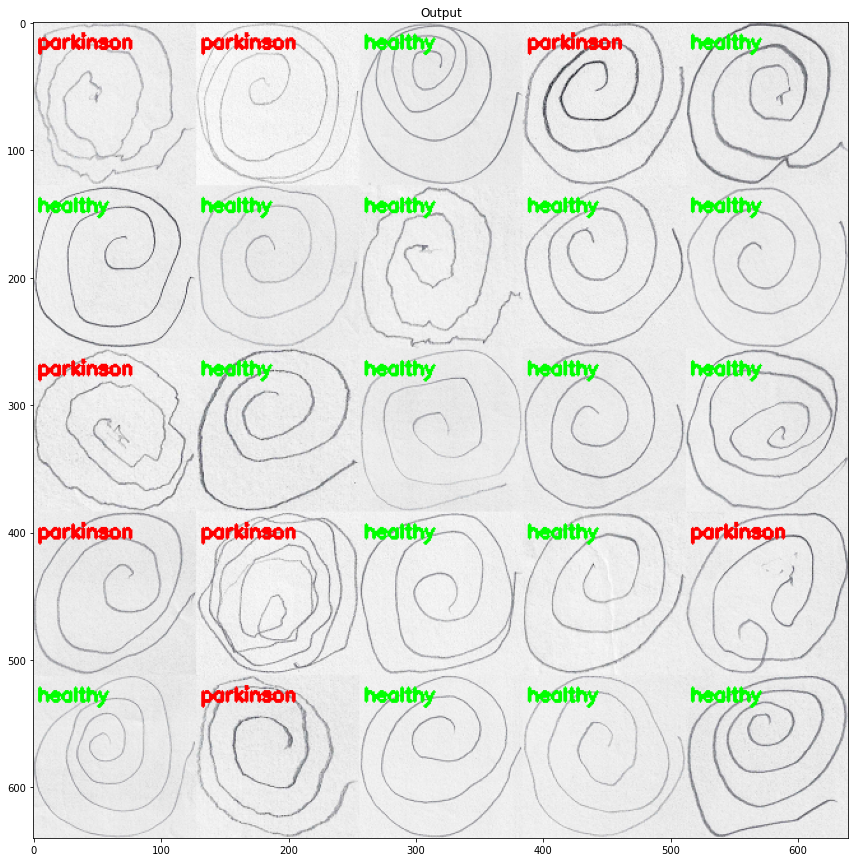

In [15]:
# randomly select a few images and then initialize the output images
# for the montage
testingPaths = list(paths.list_images(testingPath))
idxs = np.arange(0, len(testingPaths))
idxs = np.random.choice(idxs, size=(25,), replace=False)
images = []

# loop over the testing samples
for i in idxs:
	# load the testing image, clone it, and resize it
	image = cv2.imread(testingPaths[i])
	output = image.copy()
	output = cv2.resize(output, (128, 128))

	# pre-process the image in the same manner we did earlier
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	image = cv2.resize(image, (200, 200))
	image = cv2.threshold(image, 0, 255,
		cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

	# quantify the image and make predictions based on the extracted
	# features using the last trained Random Forest
	features = quantify_image(image)
	preds = model.predict([features])
	label = le.inverse_transform(preds)[0]

	# draw the colored class label on the output image and add it to
	# the set of output images
	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
		color, 2)
	images.append(output)

# create a montage using 128x128 "tiles" with 5 rows and 5 columns
montage = build_montages(images, (128, 128), (5, 5))[0]

# show the output montage
plt_imshow("Output", montage)